In [42]:
### Data Manipulation and Analysis
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical operations and array handling

### Data Visualization
import matplotlib.pyplot as plt  # Data visualization and plotting

### Statistical Functions and Tests
from scipy.stats import linregress, t, kruskal, binomtest, boxcox  # Statistical functions and tests
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation and partial autocorrelation plots

### Machine Learning Metrics
from sklearn.metrics import mean_squared_error  # Machine learning metrics for model evaluation

### Time Series Analysis and Models
import statsmodels.api as sm  # Various statistical models and tests
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model for time series forecasting
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

### Machine Learning Models
from sklearn.neural_network import MLPRegressor  # Neural network models, specifically MLPRegressor

### Utility Functions
import itertools  # Utility functions for efficient looping
import warnings # Supress Warnings

import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [58]:
# Function for the Cox-Stuart test
def cox_stuart_test(data):
    n = len(data)
    half = n // 2
    if n % 2 != 0:  # if the number of observations is odd, remove the last point to pair up
        half = (n - 1) // 2
    first_half = data[:half]
    second_half = data[-half:]
    diffs = np.sign(second_half - first_half)
    S = np.sum(diffs == -1)
    T = np.sum(diffs == 1)
    return S, T, half

# Function for inverse Box-Cox transformation
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)
    
# Function to evaluate SARIMA model
def evaluate_sarima_model(train, test, sarima_order, seasonal_order, lmbda, seed):
    np.random.seed(seed)  # Set the random seed for reproducibility
    model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test))
    predictions_inv = inv_boxcox(predictions, lmbda)
    test_inv = inv_boxcox(test, lmbda)
    rmse = np.sqrt(mean_squared_error(test_inv, predictions_inv))
    aic = model_fit.aic
    return rmse, aic

# Create function to prepare the dataset for MLP
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Define the evaluation metric (RMSE)
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
# Read the DataFrame from the CSV file
df = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df = df.loc['2007-01':'2024-07']

# Convert the generation values to thousands
df['generation_value'] = df['val_geracao'] / 1000

df

,year,month,val_geracao,generation_value
date,,,,
2007-01-01,2007,1,44518.780,44.518780
2007-02-01,2007,2,36306.070,36.306070
2007-03-01,2007,3,28729.610,28.729610
2007-04-01,2007,4,37405.240,37.405240
2007-05-01,2007,5,39726.350,39.726350
...,...,...,...,...
2024-02-01,2024,2,6339384.520,6339.384520
2024-03-01,2024,3,5302217.979,5302.217979
2024-04-01,2024,4,6003793.409,6003.793409


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_22152\1884222885.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


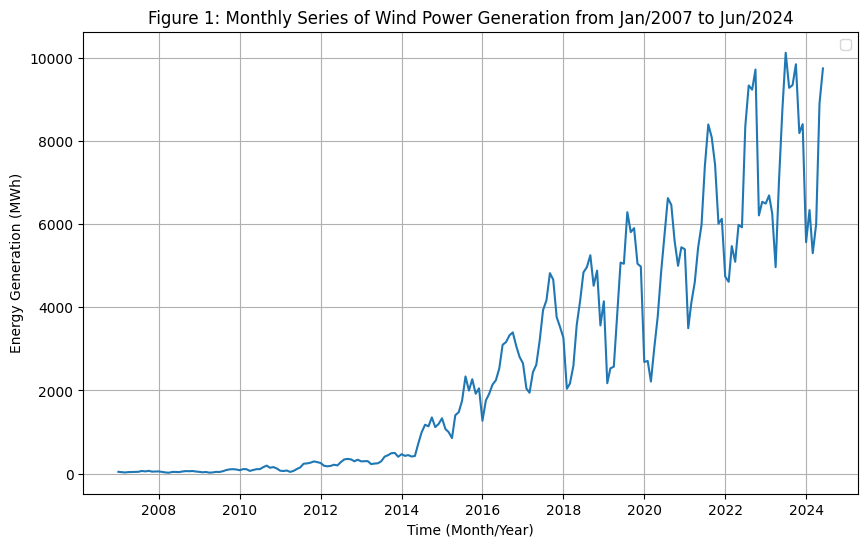

In [3]:
# Plot the training and test sets
plt.figure(figsize=(10, 6))
plt.plot(df['generation_value'])
plt.title('Figure 1: Monthly Series of Wind Power Generation from Jan/2007 to Jun/2024')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

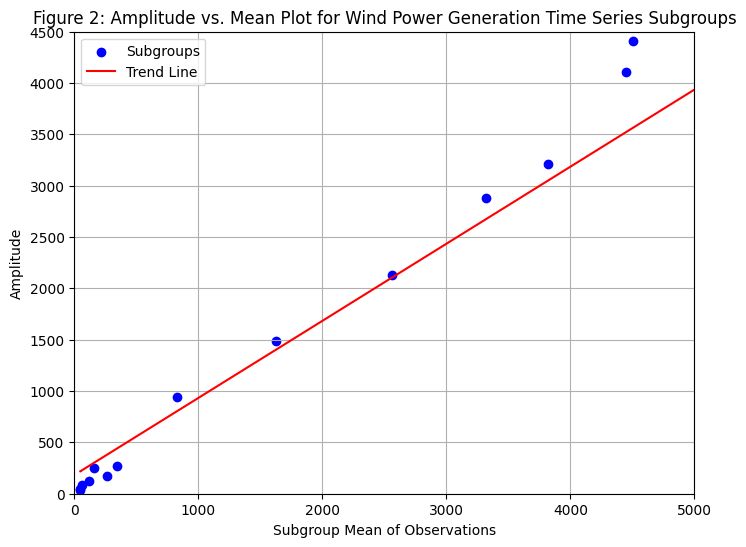

Slope:  0.7507226324259797
P-value: 3.063549414150657e-12


In [6]:
# Divide the time series into subgroups of size N (e.g., 12 months)
N = 12  # Subgroup size (e.g., 12 for annual subgroups)
subgroups = [df['generation_value'][i:i + N] for i in range(0, len(df), N)]

# Calculate the mean and amplitude for each subgroup
mean_values = [group.mean() for group in subgroups if len(group) == N]
amplitude_values = [group.max() - group.min() for group in subgroups if len(group) == N]

# Linear regression for the trend line
slope, intercept, r_value, p_value, std_err = linregress(mean_values, amplitude_values)
line = [slope * xi + intercept for xi in mean_values]

# Plot the amplitude versus mean graph
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, amplitude_values, color='blue', label='Subgroups')
plt.plot(mean_values, line, color='red', label='Trend Line')

# Add titles and labels
plt.title('Figure 2: Amplitude vs. Mean Plot for Wind Power Generation Time Series Subgroups')
plt.xlabel('Subgroup Mean of Observations')
plt.ylabel('Amplitude')

# Adjust axis limits to match the original graph
plt.xlim(0, 5000)
plt.ylim(0, 4500)

# Add grid
plt.grid(True)

# Show legend
plt.legend()

# Display the graph
plt.show()

# Calculate the t-value and the associated p-value
t_value = slope / std_err
d_f = len(mean_values) - 2  # degrees of freedom
p_value = 2 * (1 - t.cdf(np.abs(t_value), d_f))

print('Slope: ', slope)
print(f'P-value: {p_value}')


Estimated lambda value: 0.17061728155134945


<Figure size 1000x600 with 0 Axes>

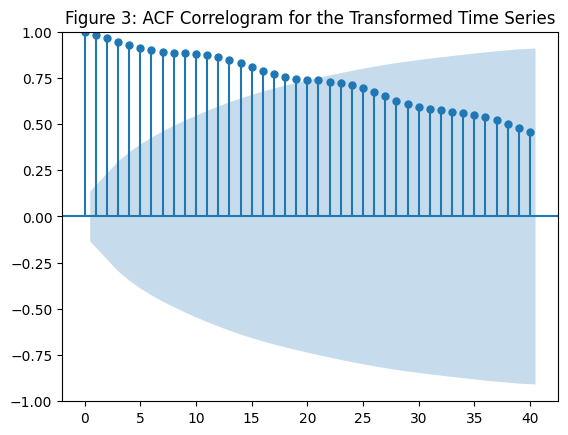

<Figure size 1000x600 with 0 Axes>

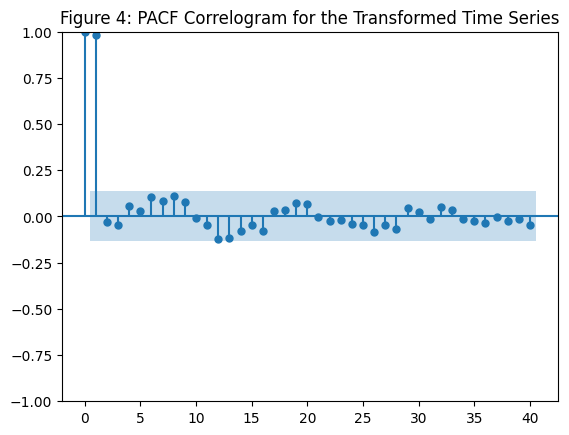

In [8]:
# Apply Box-Cox transformation
df['generation_value_boxcox'], fitted_lambda = boxcox(df['generation_value'])
print(f'Estimated lambda value: {fitted_lambda}')

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 3: ACF Correlogram for the Transformed Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 4: PACF Correlogram for the Transformed Time Series')
plt.show()

In [10]:
# Cox-Stuart test for trend
S, T, half = cox_stuart_test(df['generation_value_boxcox'])
p_value_cox_stuart = binomtest(min(S, T), n=half, p=0.5).pvalue  # Binomial test to calculate the p-value
print(f'Cox-Stuart Test: S={S}, T={T}, p-value={p_value_cox_stuart}')

Cox-Stuart Test: S=0, T=0, p-value=4.930380657631324e-32


In [11]:
# Kruskal-Wallis test for seasonality
# Group data by month to check for seasonality
df['month'] = df.index.month
seasonal_groups = [df[df['month'] == month]['generation_value_boxcox'] for month in range(1, 13)]
H, p_value_kruskal = kruskal(*seasonal_groups)
print(f'Kruskal-Wallis Test: H={H}, p-value={p_value_kruskal}')

Kruskal-Wallis Test: H=5.917959474469058, p-value=0.8787817263639477


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_22152\2529074578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['generation_value_boxcox_diff'] = df['generation_value_boxcox'].diff().dropna()


<Figure size 1000x600 with 0 Axes>

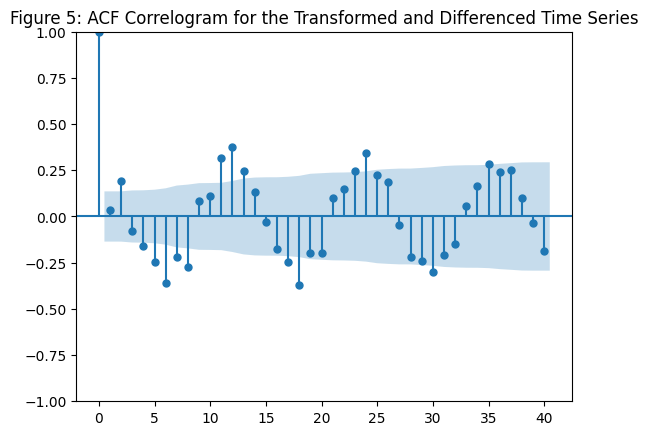

<Figure size 1000x600 with 0 Axes>

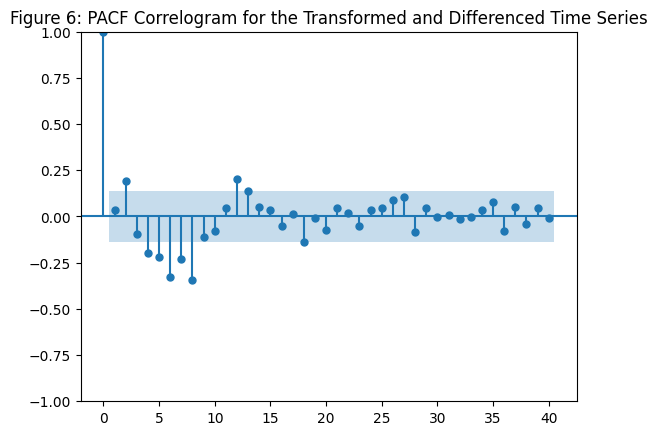

In [13]:
# Apply first-order differencing
df['generation_value_boxcox_diff'] = df['generation_value_boxcox'].diff().dropna()

# Remove N/A values
df = df.dropna(subset=['generation_value_boxcox_diff'])

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 5: ACF Correlogram for the Transformed and Differenced Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 6: PACF Correlogram for the Transformed and Differenced Time Series')
plt.show()

## SARIMA Model

In [31]:
# Parameters
p_values = [2, 4, 5, 6, 7, 8]
d = 1
q_values = [2, 4, 5, 6, 7, 8]
P = 1
D = 0
Q = 2
S = 12  # Seasonal order
seed = 42  # Random seed for reproducibility

# Apply Box-Cox transformation
df['generation_value_boxcox'], fitted_lambda = boxcox(df['generation_value'])
print(f'Estimated lambda value: {fitted_lambda}')

# Split the data into train and test sets
train = df['2007-01':'2022-12']
test = df['2023-01':'2024-07']

# Store results
results = []

# Suppress specific warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

# Generate all combinations of (p,d,q) and run SARIMA models
for p, q in itertools.product(p_values, q_values):
    if q == S:  # Avoid overlap of seasonal and non-seasonal lags
        continue
    sarima_order = (p, d, q)
    seasonal_order = (P, D, Q, S)
    try:
        rmse, aic = evaluate_sarima_model(train['generation_value_boxcox'], test['generation_value_boxcox'], sarima_order, seasonal_order, fitted_lambda, seed)
        results.append((sarima_order, seasonal_order, rmse, aic))
    except Exception as e:
        results.append((sarima_order, seasonal_order, None, None))
        print(f'Error with SARIMA order {sarima_order} and seasonal order {seasonal_order}: {e}')

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['SARIMA Order', 'Seasonal Order', 'RMSE', 'AIC'])
results_df = results_df.sort_values(by='RMSE').dropna()

# Display the best models
results_df.head()

Estimated lambda value: 0.1784361157527436
Results: [((2, 1, 2), (1, 0, 2, 12), 1070.248405790385, 314.94326969675643), ((2, 1, 4), (1, 0, 2, 12), 1076.9968163011329, 313.8783335473786), ((2, 1, 5), (1, 0, 2, 12), 1084.3136853245512, 314.113361823322), ((2, 1, 6), (1, 0, 2, 12), 1109.7726940530727, 311.7733809279653), ((2, 1, 7), (1, 0, 2, 12), 1052.0338653194851, 313.73523477952153), ((2, 1, 8), (1, 0, 2, 12), 1041.68414159755, 314.5152016480194), ((4, 1, 2), (1, 0, 2, 12), 1097.6754862098971, 316.81337873321814), ((4, 1, 4), (1, 0, 2, 12), 1268.8863652207117, 302.80395098594994), ((4, 1, 5), (1, 0, 2, 12), 1249.6234554034684, 303.4540497734101), ((4, 1, 6), (1, 0, 2, 12), 1547.304905041794, 318.7511478214502), ((4, 1, 7), (1, 0, 2, 12), 1200.0948302571019, 306.1820316440492), ((4, 1, 8), (1, 0, 2, 12), 1205.6275464185367, 307.1050547975299), ((5, 1, 2), (1, 0, 2, 12), 1076.5624292957002, 317.93840544185207), ((5, 1, 4), (1, 0, 2, 12), 1257.3475384121261, 307.7611416896265), ((5, 1, 5

,SARIMA Order,Seasonal Order,RMSE,AIC
5,"(2, 1, 8)","(1, 0, 2, 12)",1041.684142,314.515202
4,"(2, 1, 7)","(1, 0, 2, 12)",1052.033865,313.735235
0,"(2, 1, 2)","(1, 0, 2, 12)",1070.248406,314.943270
12,"(5, 1, 2)","(1, 0, 2, 12)",1076.562429,317.938405
1,"(2, 1, 4)","(1, 0, 2, 12)",1076.996816,313.878334


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_22152\4042347269.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_forecast = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]


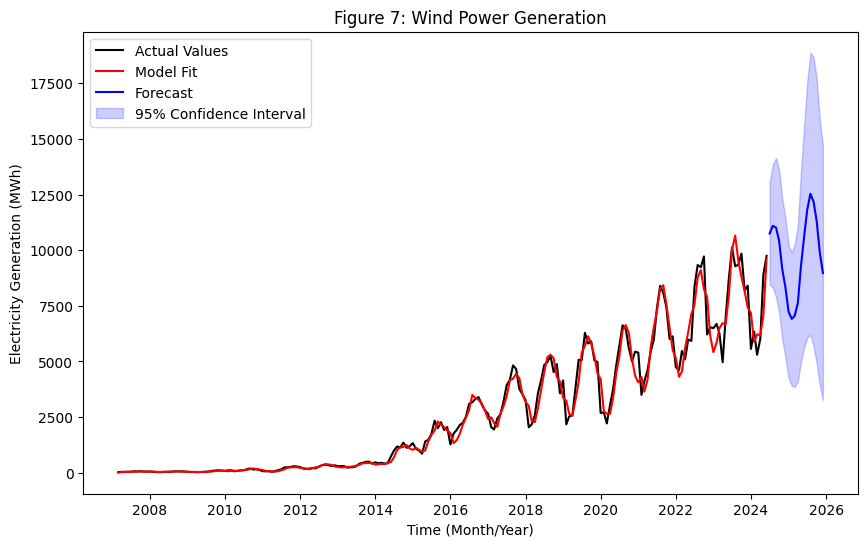

<Figure size 1000x600 with 0 Axes>

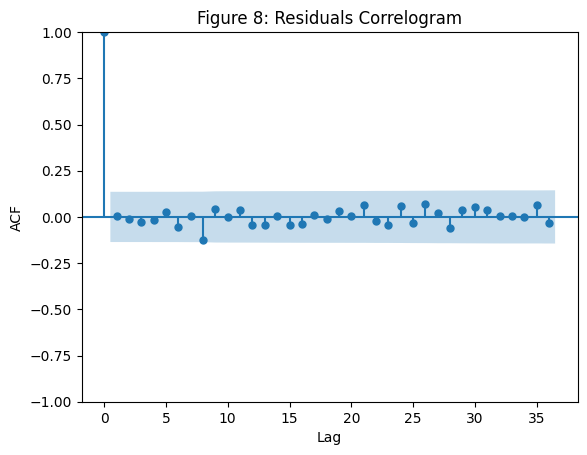

In [34]:
# Fit the chosen SARIMA model
sarima_order = (2, 1, 8)
seasonal_order = (1, 0, 2, 12)
model = SARIMAX(df['generation_value_boxcox'], order=sarima_order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecasting
steps = len(test)  # Number of steps for forecasting
predictions = model_fit.forecast(steps=steps)
predictions_inv = inv_boxcox(predictions, fitted_lambda)
df_inv = inv_boxcox(df['generation_value_boxcox'], fitted_lambda)

# Obtain forecasts with confidence intervals
forecast_results = model_fit.get_forecast(steps=steps)
conf_int = forecast_results.conf_int(alpha=0.05)

# Convert the lower and upper bounds back from Box-Cox
conf_int_inv = inv_boxcox(conf_int, fitted_lambda)

# Calculating standard deviations
std_errors = (conf_int_inv.iloc[:, 1] - conf_int_inv.iloc[:, 0]) / (2 * 1.96)

# Generate dates for the forecast period from 2024-08 to 2025-12
last_date = df.index[-1]
dates_forecast = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]

# Convert predictions_inv to DataFrame
predictions_inv_df = predictions_inv.to_frame(name='Forecast')

# Ensure std_errors is in a DataFrame
std_errors_df = pd.DataFrame(std_errors, index=predictions_inv.index, columns=['std_err'])

# Build the forecast_df DataFrame with forecasts and standard errors
forecast_df = pd.concat([predictions_inv_df, std_errors_df], axis=1)

# Calculating the 95% confidence interval
lower_bound = forecast_df['Forecast'] - 1.96 * forecast_df['std_err']
upper_bound = forecast_df['Forecast'] + 1.96 * forecast_df['std_err']

# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['generation_value'], color='black', label='Actual Values')
plt.plot(df.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Model Fit')
plt.plot(predictions_inv.index, predictions_inv, color='blue', label='Forecast')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

# Correlogram of the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=36)
plt.title('Figure 8: Residuals Correlogram')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# MLP Model

In [66]:
# Read the DataFrame from the CSV file
df = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set the date column as the index
df.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df = df.loc['2007-01':'2024-07']

# Convert the generation values to thousands
df['generation_value'] = df['val_geracao'] / 1000

# Prepare the data for training
values = df['generation_value'].values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values, look_back)

# Split the data into training and testing sets
train_end_index = df.index.get_loc('2022-12-01')
test_start_index = df.index.get_loc('2023-01-01')

trainX, testX = X[:train_end_index - look_back], X[train_end_index - look_back:test_start_index + len(df.loc['2023-01':'2024-07'])]
trainY, testY = y[:train_end_index - look_back], y[train_end_index - look_back:test_start_index + len(df.loc['2023-01':'2024-07'])]

In [67]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score: -525.0396799135835


In [68]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score (RMSE on original scale): -525.0396799135835


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
20,"(100, 100)",0.1,adam,relu,525.039680,360.551933
8,"(100, 100)",0.001,adam,relu,530.591930,363.473192
10,"(150, 150)",0.001,adam,relu,537.805565,408.201540
2,"(100, 100)",0.0001,adam,relu,544.718298,385.973822
22,"(150, 150)",0.1,adam,relu,545.278087,411.786652


In [82]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore = np.sqrt(mean_squared_error(testY, testPredict))

print(f'Train RMSE: {trainScore}')
print(f'Test RMSE: {testScore}')

Train RMSE: 146.88965191676115
Test RMSE: 1493.4620412670347


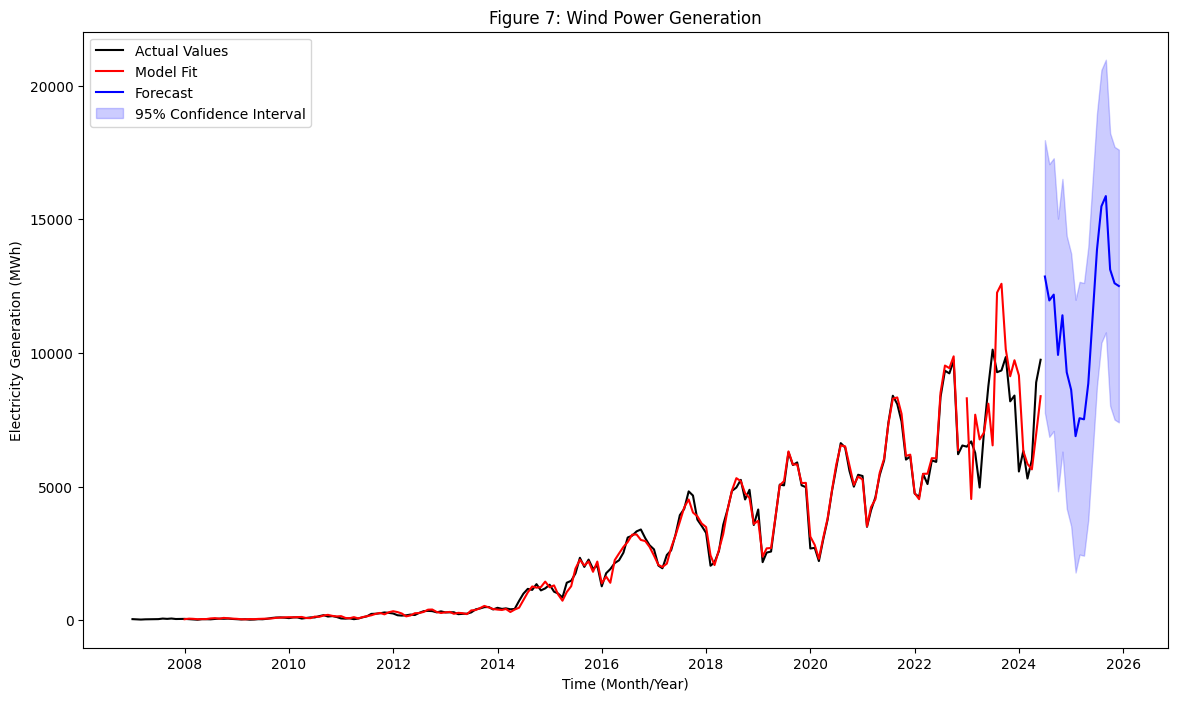

In [83]:
# Make future predictions from July 2024 to December 2025
future_steps = 18  # Number of months from July 2024 to December 2025
last_window = values[-look_back:].reshape(1, -1)

future_predictions = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions = np.array(future_predictions).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2024-07-01', periods=future_steps, freq='MS')
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['generation_value'])

# Calculate confidence intervals
prediction_intervals = []
std_future = np.std(future_predictions)
for pred in future_predictions:
    lower_bound = pred - 1.96 * std_future  # 95% confidence interval lower bound
    upper_bound = pred + 1.96 * std_future  # 95% confidence interval upper bound
    prediction_intervals.append((lower_bound[0], upper_bound[0]))

prediction_intervals = np.array(prediction_intervals)

# Combine training and test predictions to create a continuous series
all_predictions = np.empty_like(values)
all_predictions[:, :] = np.nan

# Adjust training predictions for plotting
trainPredictPlot = np.empty_like(values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Adjust test predictions for plotting
testPredictPlot = np.empty_like(values)
testPredictPlot[:, :] = np.nan
test_start = len(trainPredictPlot) - len(testPredict)

testPredictPlot[test_start:test_start + len(testPredict), :] = testPredict

# Combine both predictions into all_predictions
all_predictions[look_back:len(trainPredict) + look_back] = trainPredict
all_predictions[test_start:test_start + len(testPredict)] = testPredict


# Plot actual values, model fit, forecast, and confidence intervals
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['generation_value'], label='Actual Values', color='black')
plt.plot(df.index[look_back:len(all_predictions)], all_predictions[look_back:], label='Model Fit', color='red')
plt.plot(future_df.index, future_predictions, label='Forecast', color='blue')
plt.fill_between(future_df.index, prediction_intervals[:, 0], prediction_intervals[:, 1], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.title('Figure 7: Wind Power Generation')
plt.legend()
plt.show()